
# Analiza zbioru danych: Car Evaluation (UCI)

Ten notebook zawiera kompleksową analizę eksploracyjną (EDA) klasycznego zbioru **Car Evaluation** (UCI).
Analiza jest zgodna z wytycznymi:

- **Sprawdź pochodzenie i cel powstania**
- **Na jakie pytanie chcemy odpowiedzieć?**
- **Atrybuty: liczba, typ, rozkład, brakujące wartości**
- **Jeżeli są artykuły, to sprawdź zastosowane w nich metody i z jakim skutkiem**
- **Czy będzie to zadanie trudne / proste dla sieci neuronowej?**
- **Schemat omówienia zbioru**: typy zmiennych (ilościowe/cząstkowe vs jakościowe), rozkłady cech i zmiennej przewidywanej (y), równowaga klas, korelacje (dla zmiennych porządkowych), przykładowe testy (np. chi²).



## Pochodzenie i cel powstania

Zbiór **Car Evaluation** powstał poprzez mapowanie wyników zadań **AHP** (Analytic Hierarchy Process) odnoszących się do oceny samochodów. Zmienna docelowa to kategoria jakości/akceptowalności samochodu (`class`), a cechy wejściowe to krótkie, dyskretne oceny różnych aspektów (koszt zakupu, koszt utrzymania, liczba drzwi, liczba miejsc, pojemność bagażnika, bezpieczeństwo).

**Cel**: przewidywanie kategorii akceptowalności samochodu na podstawie jego atrybutów.



## Analiza plików meta: `car.names` i `car.c45-names`

Poniżej wczytujemy i analizujemy dwa dodatkowe pliki opisowe dostarczone wraz ze zbiorem danych.

Pliki te zawierają **informacje o pochodzeniu, atrybutach, ich wartościach oraz klasach**.  
Są one kluczowe przy pełnym omówieniu zbioru danych — stanowią oryginalną dokumentację z repozytorium UCI.


In [4]:

# Wczytaj i wypisz zawartość pliku car.names bezpośrednio podczas uruchamiania notebooka
from pathlib import Path

names_path = Path("car.names")
print("===== Zawartość pliku car.names =====\n")
with names_path.open("r", encoding="utf-8", errors="ignore") as f:
    car_names_text = f.read()
print(car_names_text)


===== Zawartość pliku car.names =====

1. Title: Car Evaluation Database

2. Sources:
   (a) Creator: Marko Bohanec
   (b) Donors: Marko Bohanec   (marko.bohanec@ijs.si)
               Blaz Zupan      (blaz.zupan@ijs.si)
   (c) Date: June, 1997

3. Past Usage:

   The hierarchical decision model, from which this dataset is
   derived, was first presented in 

   M. Bohanec and V. Rajkovic: Knowledge acquisition and explanation for
   multi-attribute decision making. In 8th Intl Workshop on Expert
   Systems and their Applications, Avignon, France. pages 59-78, 1988.

   Within machine-learning, this dataset was used for the evaluation
   of HINT (Hierarchy INduction Tool), which was proved to be able to
   completely reconstruct the original hierarchical model. This,
   together with a comparison with C4.5, is presented in

   B. Zupan, M. Bohanec, I. Bratko, J. Demsar: Machine learning by
   function decomposition. ICML-97, Nashville, TN. 1997 (to appear)

4. Relevant Information Para

In [5]:

# Wczytaj i wypisz zawartość pliku car.c45-names bezpośrednio podczas uruchamiania notebooka
from pathlib import Path

c45_path = Path("car.c45-names")
print("===== Zawartość pliku car.c45-names =====\n")
with c45_path.open("r", encoding="utf-8", errors="ignore") as f:
    car_c45_names_text = f.read()
print(car_c45_names_text)


===== Zawartość pliku car.c45-names =====

| names file (C4.5 format) for car evaluation domain

| class values

unacc, acc, good, vgood

| attributes

buying:   vhigh, high, med, low.
maint:    vhigh, high, med, low.
doors:    2, 3, 4, 5more.
persons:  2, 4, more.
lug_boot: small, med, big.
safety:   low, med, high.




### Wnioski z plików meta

- Plik `car.names` opisuje kontekst powstania zbioru (UCI Machine Learning Repository, twórca: Marko Bohanec, Institut "Jožef Stefan").  
  Zawiera definicję problemu klasyfikacyjnego oraz pełną listę atrybutów i klas.

- Plik `car.c45-names` przedstawia te same informacje w formacie **systemu C4.5**, który używany był do testowania algorytmu **drzew decyzyjnych Quinlana**.  
  Format ten definiuje zmienną docelową, listę cech i ich możliwe wartości.

Dzięki tym plikom wiemy, że:
- Wszystkie atrybuty są **dyskretne** (kategoryczne), o ograniczonym zbiorze wartości.  
- Zmienna docelowa `class` przyjmuje cztery wartości: `unacc`, `acc`, `good`, `vgood`.  
- Dane pochodzą z **procedury AHP** (Analytic Hierarchy Process), co potwierdza charakter ekspercki, a nie pomiarowy.



## Na jakie pytanie chcemy odpowiedzieć?

> **Która klasa akceptowalności (`unacc`, `acc`, `good`, `vgood`) zostanie przypisana danemu samochodowi na podstawie cech: `buying`, `maint`, `doors`, `persons`, `lug_boot`, `safety`?**


In [6]:

# Pakiety
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, spearmanr

# Wczytanie danych
colnames = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df = pd.read_csv("car.data", header=None, names=colnames)

# Podgląd
df.head()


,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [7]:

print("Liczba wierszy i kolumn:", df.shape)
print("\nLiczność unikalnych wartości w kolumnach:")
for c in df.columns:
    print(f"- {c}: {df[c].nunique()} unikalnych wartości -> {sorted(df[c].unique())}")

print("\nBrakujące wartości w każdej kolumnie:")
print(df.isna().sum())

# Typy danych
df.dtypes


Liczba wierszy i kolumn: (1728, 7)

Liczność unikalnych wartości w kolumnach:
- buying: 4 unikalnych wartości -> ['high', 'low', 'med', 'vhigh']
- maint: 4 unikalnych wartości -> ['high', 'low', 'med', 'vhigh']
- doors: 4 unikalnych wartości -> ['2', '3', '4', '5more']
- persons: 3 unikalnych wartości -> ['2', '4', 'more']
- lug_boot: 3 unikalnych wartości -> ['big', 'med', 'small']
- safety: 3 unikalnych wartości -> ['high', 'low', 'med']
- class: 4 unikalnych wartości -> ['acc', 'good', 'unacc', 'vgood']

Brakujące wartości w każdej kolumnie:
buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64


buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
class       object
dtype: object


## Atrybuty: liczba, typ, rozkład, brakujące wartości

- **Liczba atrybutów (cech)**: 6 (wszystkie kategoryczne, dyskretne, w większości porządkowe).
- **Zmienna przewidywana (y)**: `class` (kategorie: `unacc`, `acc`, `good`, `vgood`).
- **Brakujące wartości**: w oryginalnym zbiorze ich nie ma — poniższa sekcja to potwierdzi.
- **Typy**:
  - `buying`, `maint`: kategoryczne **porządkowe** (`vhigh` > `high` > `med` > `low`).
  - `doors`: kategoryczna **porządkowa** (`2` < `3` < `4` < `5more`).
  - `persons`: kategoryczna **porządkowa** (`2` < `4` < `more`).
  - `lug_boot`: kategoryczna **porządkowa** (`small` < `med` < `big`).
  - `safety`: kategoryczna **porządkowa** (`low` < `med` < `high`).


## Rozkład zmiennej przewidywanej (y)

class
acc       384
good       69
unacc    1210
vgood      65
Name: count, dtype: int64


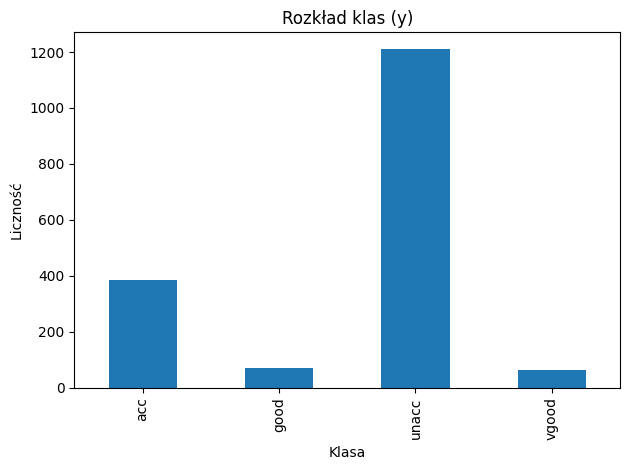

In [8]:

class_counts = df['class'].value_counts().sort_index()
print(class_counts)
ax = class_counts.plot(kind='bar', title='Rozkład klas (y)')
ax.set_xlabel('Klasa')
ax.set_ylabel('Liczność')
plt.tight_layout()
plt.show()



**Równowaga klas:** Powyższy wykres pokazuje, czy klasy są zrównoważone. Jeżeli jedna dominuje (co w tym zbiorze bywa częste dla `unacc`), można rozważyć:
- **Ważenie klas** w modelach (class weights),
- **Resampling**: *undersampling* klasy dominującej lub *oversampling* mniejszych (np. SMOTE dla reprezentacji numerycznych),
- **Dobór metryk** odpornych na niezbalansowanie (macro-F1, balanced accuracy).


## Rozkłady cech (kilka wykresów)

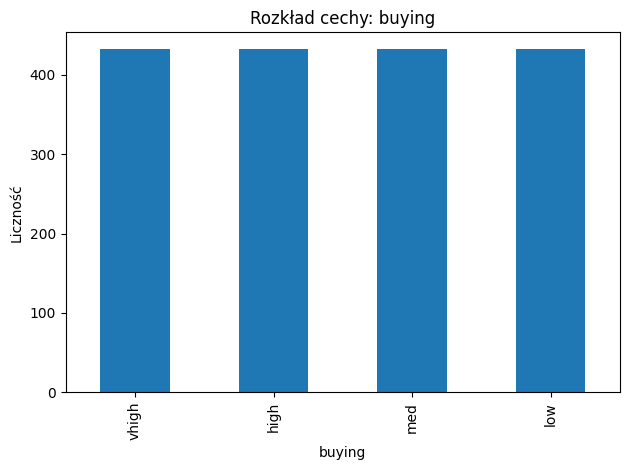

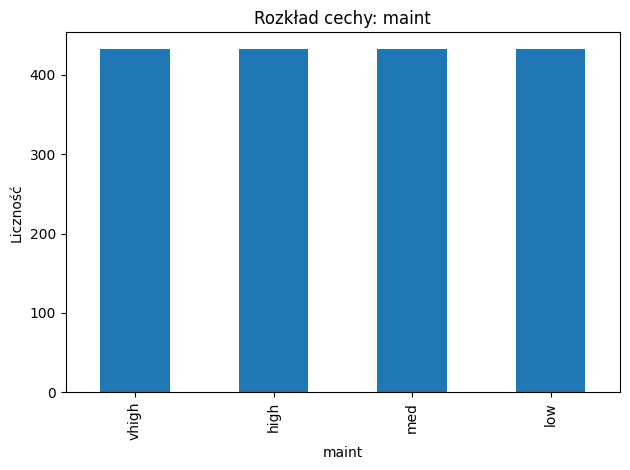

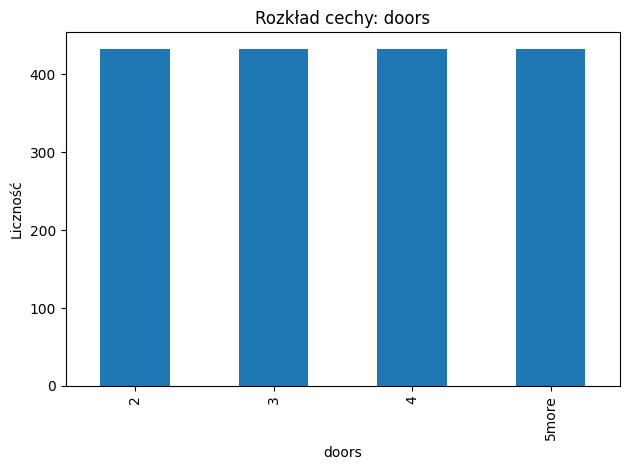

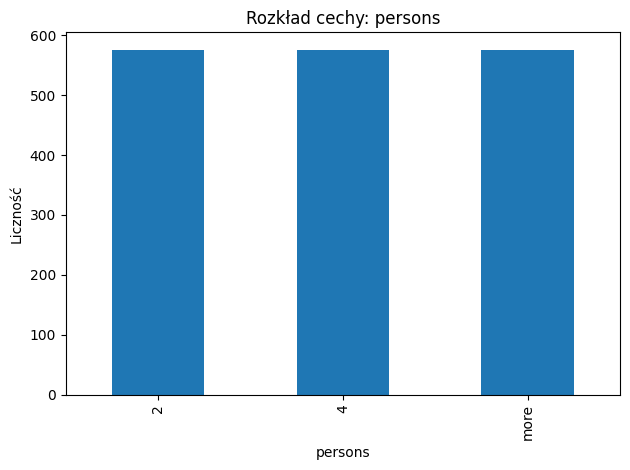

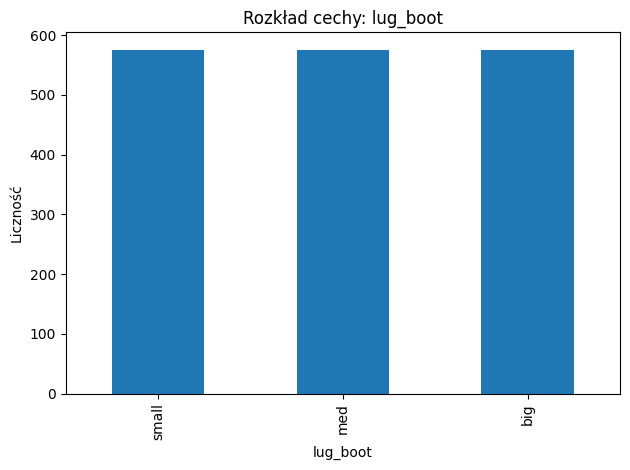

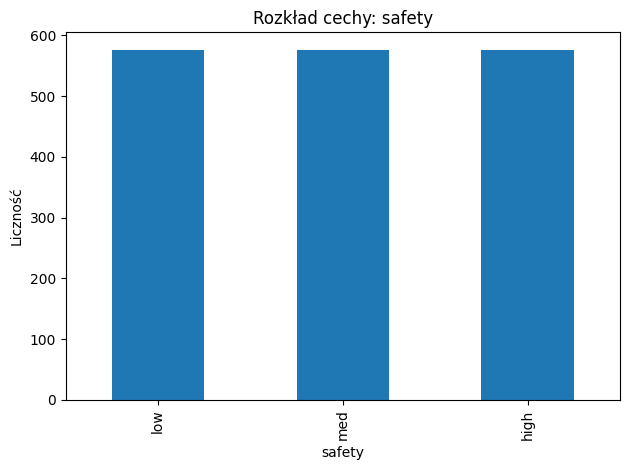

In [9]:

for col in ['buying','maint','doors','persons','lug_boot','safety']:
    counts = df[col].value_counts()
    ax = counts.plot(kind='bar', title=f'Rozkład cechy: {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Liczność')
    plt.tight_layout()
    plt.show()


## Zależności cecha ↔ klasa (crosstab + wykresy)

class,acc,good,unacc,vgood
buying,,,,
high,108,0,324,0
low,89,46,258,39
med,115,23,268,26
vhigh,72,0,360,0


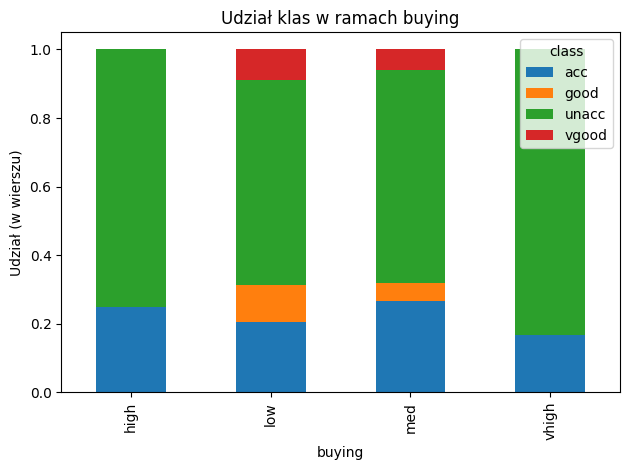

class,acc,good,unacc,vgood
maint,,,,
high,105,0,314,13
low,92,46,268,26
med,115,23,268,26
vhigh,72,0,360,0


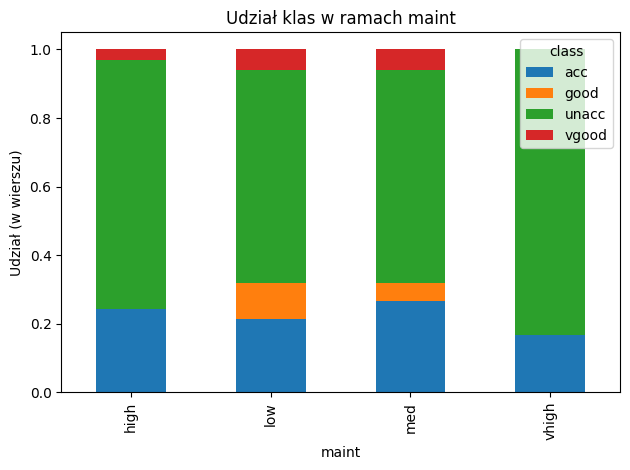

class,acc,good,unacc,vgood
doors,,,,
2,81,15,326,10
3,99,18,300,15
4,102,18,292,20
5more,102,18,292,20


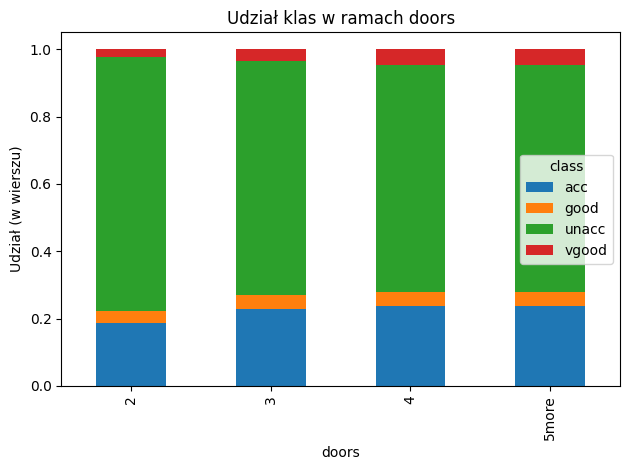

class,acc,good,unacc,vgood
persons,,,,
2,0,0,576,0
4,198,36,312,30
more,186,33,322,35


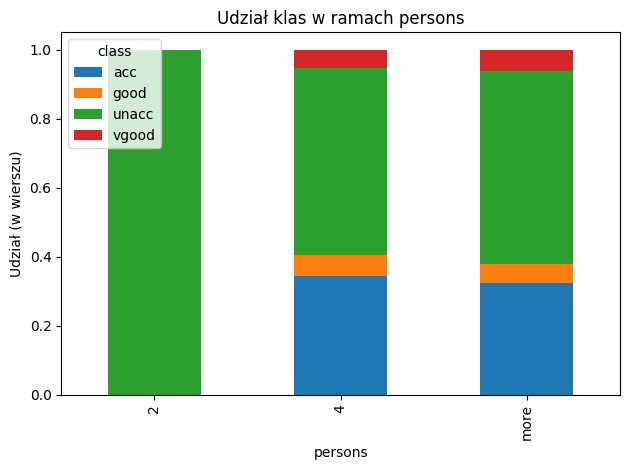

class,acc,good,unacc,vgood
lug_boot,,,,
big,144,24,368,40
med,135,24,392,25
small,105,21,450,0


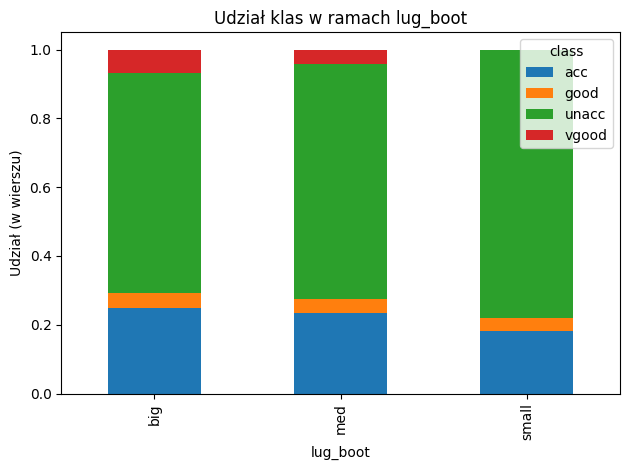

class,acc,good,unacc,vgood
safety,,,,
high,204,30,277,65
low,0,0,576,0
med,180,39,357,0


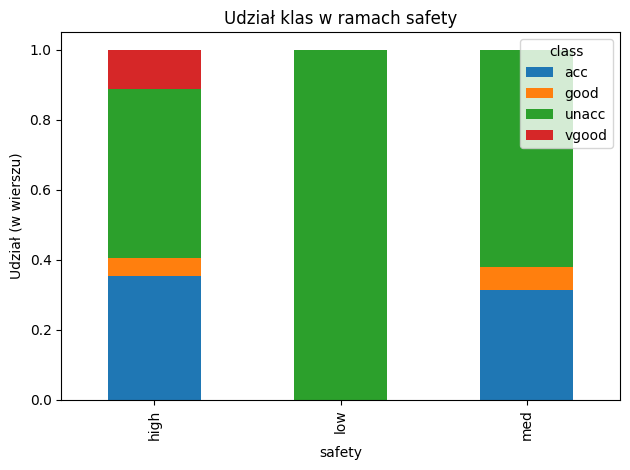

In [10]:

for col in ['buying','maint','doors','persons','lug_boot','safety']:
    ct = pd.crosstab(df[col], df['class'])
    display(ct)
    # Wykres skumulowany (jeden wykres na cechę)
    ax = (ct / ct.sum(axis=1).values.reshape(-1,1)).plot(kind='bar', stacked=True, title=f'Udział klas w ramach {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Udział (w wierszu)')
    plt.tight_layout()
    plt.show()


## Test niezależności chi²: cecha vs klasa

In [11]:
# cecha wpływa na zmienną wynikową
results = []
for col in ['buying','maint','doors','persons','lug_boot','safety']:
    table = pd.crosstab(df[col], df['class'])
    chi2, p, dof, exp = chi2_contingency(table)
    significance_level = 0.05
    if p < significance_level:
        results.append({'cecha': col, 'chi2': chi2, 'p_value': p})
chi_df = pd.DataFrame(results).sort_values('p_value')
# chi_df["p_value"] = chi_df["p_value"]
chi_df
# chia = chi_df[chi_df["p_value" < 0.05]]
# chia


,cecha,chi2,p_value
4,safety,479.322440,2.389155e-100
2,persons,371.336728,4.039968e-77
0,buying,189.243010,5.928063e-36
1,maint,142.940530,2.547652e-26
3,lug_boot,53.282025,1.029440e-09


## Korelacje (Spearman) dla kodowania porządkowego

In [12]:

# Mapowania porządkowe
maps = {
    'buying': {'vhigh':3,'high':2,'med':1,'low':0},
    'maint':  {'vhigh':3,'high':2,'med':1,'low':0},
    'doors':  {'2':0,'3':1,'4':2,'5more':3},
    'persons':{'2':0,'4':1,'more':2},
    'lug_boot':{'small':0,'med':1,'big':2},
    'safety': {'low':0,'med':1,'high':2},
    'class':  {'unacc':0,'acc':1,'good':2,'vgood':3}
}
df_ord = df.replace(maps)

corrs = {}
for col in ['buying','maint','doors','persons','lug_boot','safety']:
    rho, p = spearmanr(df_ord[col], df_ord['class'])
    corrs[col] = (rho)

corr_df = pd.DataFrame(corrs, index=['spearman_rho']).T.sort_values('spearman_rho', ascending=False)
corr_df


C:\Users\jakub\AppData\Local\Temp\ipykernel_478464\765426415.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ord = df.replace(maps)


,spearman_rho
safety,0.467165
persons,0.389372
lug_boot,0.137534
doors,0.064560
maint,-0.206508
buying,-0.236949


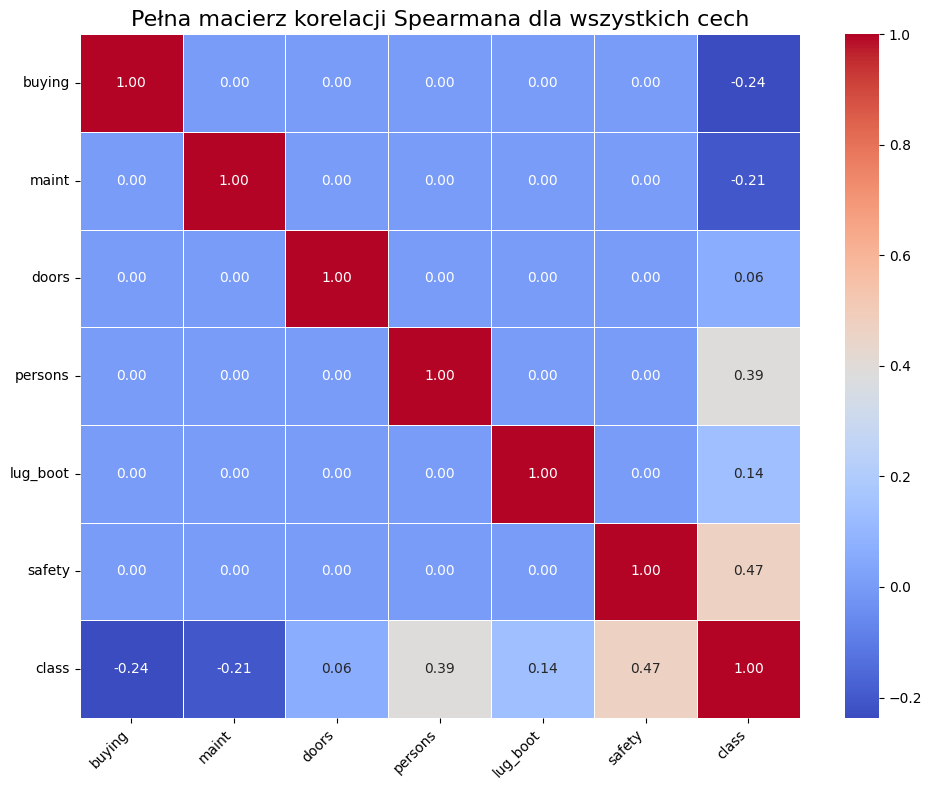

In [13]:
import seaborn as sns


correlation_matrix = df_ord.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Pełna macierz korelacji Spearmana dla wszystkich cech', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [19]:
from sklearn.preprocessing import MinMaxScaler

X = df_ord.drop('class', axis = 1).values

y = df_ord['class'].values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


# Implementacja algorytmu Kohonena
 Wykorzystujemy siatkę 15x15 bo korzystamy ze wzoru M = 5 * sqrt(N), gdzie M to jest całkowita liczba neuronów na mapie, a N to liczba próbek w zbiorze danych, więc pierwiastek z 1728 to około 41,57 i jak pomnożymy to razy 5 to otrzymamy 207.8 neuronów, czyli okolo 14.4 powinna miec siatka, czyli wykorzystujemy siatkę 14x14


Zainicjowano siatkę SOM: 15x15 dla danych 6-wymiarowych.
Rozpoczynam trening
Iteracja 0/1000, Promień: 7.50
Iteracja 100/1000, Promień: 6.75
Iteracja 200/1000, Promień: 6.00
Iteracja 300/1000, Promień: 5.25
Iteracja 400/1000, Promień: 4.50
Iteracja 500/1000, Promień: 3.75
Iteracja 600/1000, Promień: 3.00
Iteracja 700/1000, Promień: 2.25
Iteracja 800/1000, Promień: 1.50
Iteracja 900/1000, Promień: 0.75
Trening zakończony w 0.51 s.

--- Wyniki ---
Błąd kwantyzacji (QE): 0.6741
Błąd topograficzny (TE): 0.0446


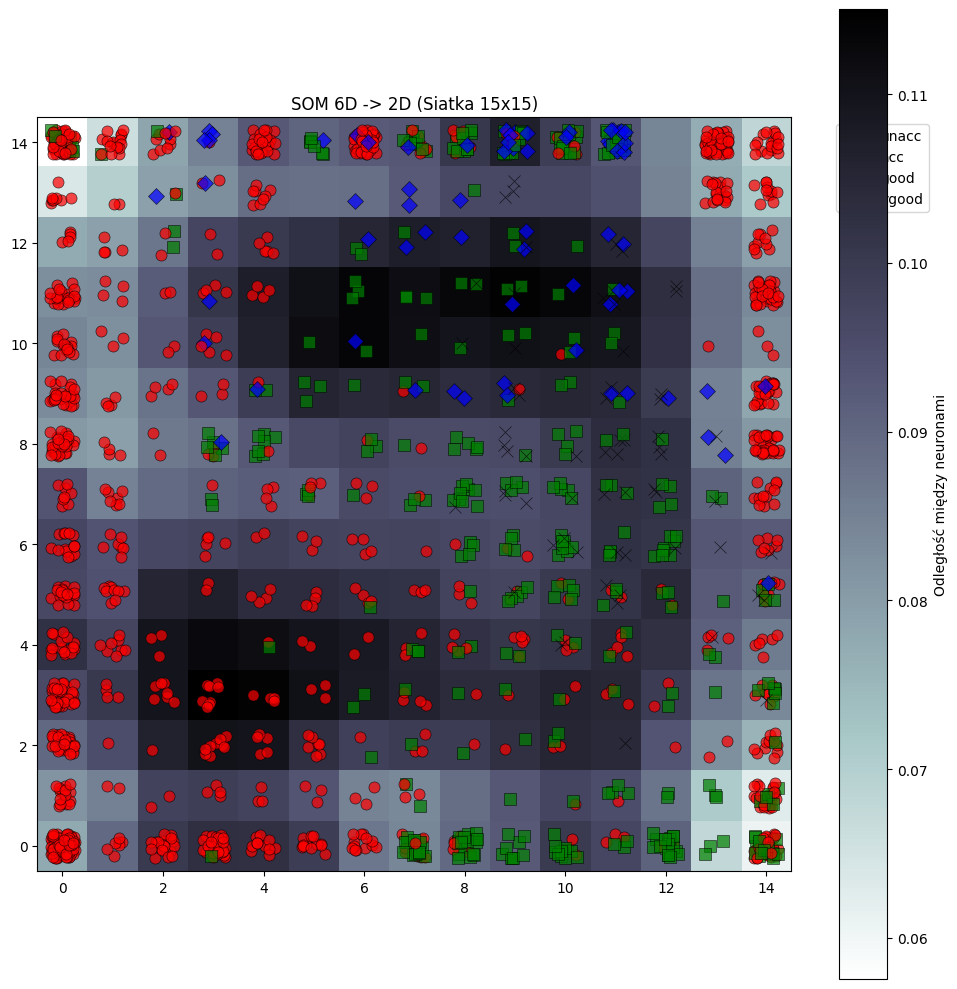

In [ ]:
import time
from matplotlib.lines import Line2D


def dist_nd(p1, p2):
    return np.sum((p1 - p2)**2)

def phi(ix, iy, kx, ky, d):
    return np.exp(-((ix - kx)**2 + (iy - ky)**2) / (d**2))

grid_size = 15
input_dim = 6
rounds = 1000
learning_rate = 0.05
radius = grid_size / 2.0


np.random.seed(42)
weights = np.random.rand(grid_size, grid_size, input_dim)

print(f"Zainicjowano siatkę SOM: {grid_size}x{grid_size} dla danych {input_dim}-wymiarowych.")

print("Rozpoczynam trening")

start_time = time.time()

num_samples = X_scaled.shape[0]

for iteration in range(rounds):
    curr_rate = learning_rate * (1 - iteration / rounds)
    curr_radius = radius * (1 - iteration / rounds)
    
    if curr_radius < 0.1:
        curr_radius = 0.1

    idx = np.random.randint(0, num_samples)
    sample = X_scaled[idx]
    
    dists = np.sum((weights - sample)**2, axis=2)
    bmu_idx = np.argmin(dists)
    bmu_x, bmu_y = np.unravel_index(bmu_idx, (grid_size, grid_size))
    
    start_x = max(0, int(bmu_x - curr_radius * 3))
    end_x = min(grid_size, int(bmu_x + curr_radius * 3 + 1))
    start_y = max(0, int(bmu_y - curr_radius * 3))
    end_y = min(grid_size, int(bmu_y + curr_radius * 3 + 1))

    for i in range(start_x, end_x):
        for j in range(start_y, end_y):
            influence = phi(bmu_x, bmu_y, i, j, curr_radius)
            
            weights[i, j] += curr_rate * influence * (sample - weights[i, j])

    if iteration % 100 == 0:
        print(f"Iteracja {iteration}/{rounds}, Promień: {curr_radius:.2f}")

print(f"Trening zakończony w {time.time() - start_time:.2f} s.")

qe_sum = 0
for x in X_scaled:
    dists = np.sum((weights - x)**2, axis=2)
    qe_sum += np.sqrt(np.min(dists))
quantization_error = qe_sum / num_samples


te_count = 0
for x in X_scaled:
    dists = np.sum((weights - x)**2, axis=2)
    flat_indices = np.argsort(dists, axis=None)
    
    bmu1 = np.unravel_index(flat_indices[0], (grid_size, grid_size))
    bmu2 = np.unravel_index(flat_indices[1], (grid_size, grid_size))
    
    grid_dist = np.sqrt((bmu1[0]-bmu2[0])**2 + (bmu1[1]-bmu2[1])**2)
    
    if grid_dist > np.sqrt(2):
        te_count += 1
topographic_error = te_count / num_samples

print(f"\n--- Wyniki ---")
print(f"Błąd kwantyzacji (QE): {quantization_error:.4f}")
print(f"Błąd topograficzny (TE): {topographic_error:.4f}")


u_matrix = np.zeros((grid_size, grid_size))
for i in range(grid_size):
    for j in range(grid_size):
        nb_dists = []
        if i > 0: nb_dists.append(np.sqrt(dist_nd(weights[i,j], weights[i-1,j])))
        if i < grid_size-1: nb_dists.append(np.sqrt(dist_nd(weights[i,j], weights[i+1,j])))
        if j > 0: nb_dists.append(np.sqrt(dist_nd(weights[i,j], weights[i,j-1])))
        if j < grid_size-1: nb_dists.append(np.sqrt(dist_nd(weights[i,j], weights[i,j+1])))
        
        u_matrix[i, j] = np.mean(nb_dists)

plt.figure(figsize=(10, 10))
plt.imshow(u_matrix.T, cmap='bone_r', origin='lower')
plt.colorbar(label='Odległość między neuronami')

markers = ['o', 's', 'D', 'x']
colors = ['r', 'g', 'b', 'orange'] 

jitter = lambda: (np.random.rand() - 0.5) * 0.5 

for i, x in enumerate(X_scaled):
    dists = np.sum((weights - x)**2, axis=2)
    bmu_idx = np.argmin(dists)
    bx, by = np.unravel_index(bmu_idx, (grid_size, grid_size))
    
    plt.plot(bx + jitter(), by + jitter(), 
             marker=markers[y[i]], 
             color=colors[y[i]], 
             markersize=8, 
             markeredgecolor='black',
             markeredgewidth=0.5,
             alpha=0.7)

legend_elements = [Line2D([0], [0], marker=m, color='w', label=l,
                          markerfacecolor=c, markeredgecolor='k', markersize=10) 
                   for m, c, l in zip(markers, colors, ['unacc', 'acc', 'good', 'vgood'])]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.title(f"SOM 2D (Siatka {grid_size}x{grid_size})")
plt.tight_layout()
plt.show()

# Wniosek
Topographic Error (TE) = 0.0446: Wynik ten oznacza, że struktura topologiczna danych została zachowana w 95.5% przypadków. Niska wartość błędu świadczy o tym, że proces "rozprostowywania" siatki neuronów przebiegł pomyślnie, a mapa jest wiarygodnym odwzorowaniem 6-wymiarowej przestrzeni na płaszczyznę 2D. Potwierdza to czytelność wygenerowanej macierzy U-Matrix.

Quantization Error (QE) = 0.6741: Wartość błędu kwantyzacji wskazuje na średni poziom dopasowania wag neuronów do danych wejściowych. Biorąc pod uwagę stochastyczny charakter danych, wynik ten jest satysfakcjonujący i świadczy o tym, że sieć dokonała poprawnej generalizacji, znajdując centra klastrów, zamiast zapamiętywać szum w danych.